<a href="https://colab.research.google.com/github/Chada2307/MoodTracker/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

##drive.mount('/content')  # Podłączanie Dysku Google
data_path = "/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/archive.zip"  # Ścieżka do pliku


with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [2]:
os.listdir("/content/test")

['fear', 'neutral', 'surprise', 'angry', 'sad', 'happy', 'disgust']

In [6]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
data_dir = "/content"

batch_size=128
num_workers = 2

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory = True)

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

print(os.cpu_count())

Train dataset size: 28709 images
Test dataset size: 7178 images
2


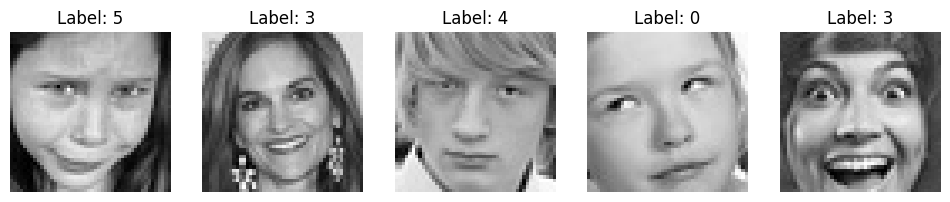

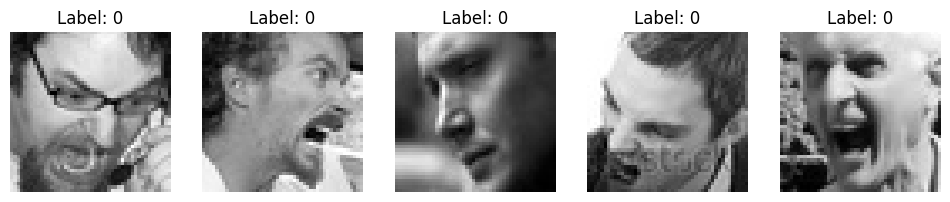

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

dataiter1 = iter(test_loader)
images, labels = next(dataiter1)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class EmocjeCNN(nn.Module):
  def __init__(self):
    super(EmocjeCNN,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(128 * 6 * 6 , 256)
    self.fc2 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.25)
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 128 * 6 * 6)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.dropout(x)
    return x

In [9]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmocjeCNN().to(device)

kryteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

print("GPU dostępne:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



GPU dostępne: True
Nazwa GPU: Tesla T4


In [13]:
def validate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [10]:
### tego nie uzywamy na razie
from sklearn.metrics import accuracy_score

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

scaler = torch.amp.GradScaler()
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = kryteria(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        accuracy = calculate_accuracy(outputs, labels)
        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    train_acc = 100 * correct / total
    test_acc = validate_model(model, test_loader, device)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)



    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
torch.save(model.state_dict(), 'model.pth')

Epoch 1/5, Loss: 1.800065321486883
Epoch 2/5, Loss: 1.6552521019576651
Epoch 3/5, Loss: 1.5390821666122811
Epoch 4/5, Loss: 1.4416565518071232
Epoch 5/5, Loss: 1.3691253117835336


In [21]:
train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = kryteria(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # sumujemy przez całą epokę

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / total

    # Walidacja (z test_loss):
    model.eval()
    correct_test = 0
    total_test = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = kryteria(outputs, labels)

            test_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_loss = test_running_loss / total_test

    # Zbieranie danych do wykresu
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Accuracy: {train_acc:.2f}%, Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%, Loss: {test_loss:.4f}")
    print("-" * 40)
torch.save(model.state_dict(), 'model.pth')

Epoch [1/15]
Train Accuracy: 63.29%, Loss: 0.9286
Test Accuracy: 56.88%, Loss: 1.2267
----------------------------------------
Epoch [2/15]
Train Accuracy: 66.39%, Loss: 0.8436
Test Accuracy: 57.69%, Loss: 1.2514
----------------------------------------
Epoch [3/15]
Train Accuracy: 69.14%, Loss: 0.7548
Test Accuracy: 55.91%, Loss: 1.4315
----------------------------------------
Epoch [4/15]
Train Accuracy: 71.95%, Loss: 0.6677
Test Accuracy: 57.12%, Loss: 1.3507
----------------------------------------
Epoch [5/15]
Train Accuracy: 75.12%, Loss: 0.5850
Test Accuracy: 57.17%, Loss: 1.5363
----------------------------------------
Epoch [6/15]
Train Accuracy: 77.25%, Loss: 0.5152
Test Accuracy: 57.70%, Loss: 1.6134
----------------------------------------
Epoch [7/15]
Train Accuracy: 79.01%, Loss: 0.4604
Test Accuracy: 57.13%, Loss: 1.7553
----------------------------------------
Epoch [8/15]
Train Accuracy: 80.16%, Loss: 0.4260
Test Accuracy: 57.77%, Loss: 1.8747
-------------------------

In [11]:

model.eval()
correct_val = 0
total_val = 0
val_loss = 0.0
for batch_idx, (images, labels) in enumerate(test_loader):
    try:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = kryteria(outputs, labels)
              val_loss += loss.item()
              accuracy = calculate_accuracy(outputs, labels)
              correct_val += (outputs.argmax(1) == labels).sum().item()
              total_val += labels.size(0)
    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")

val_losses.append(val_loss / len(test_loader))
val_accuracies.append(correct_val / total_val)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")


NameError: name 'val_accuracy' is not defined

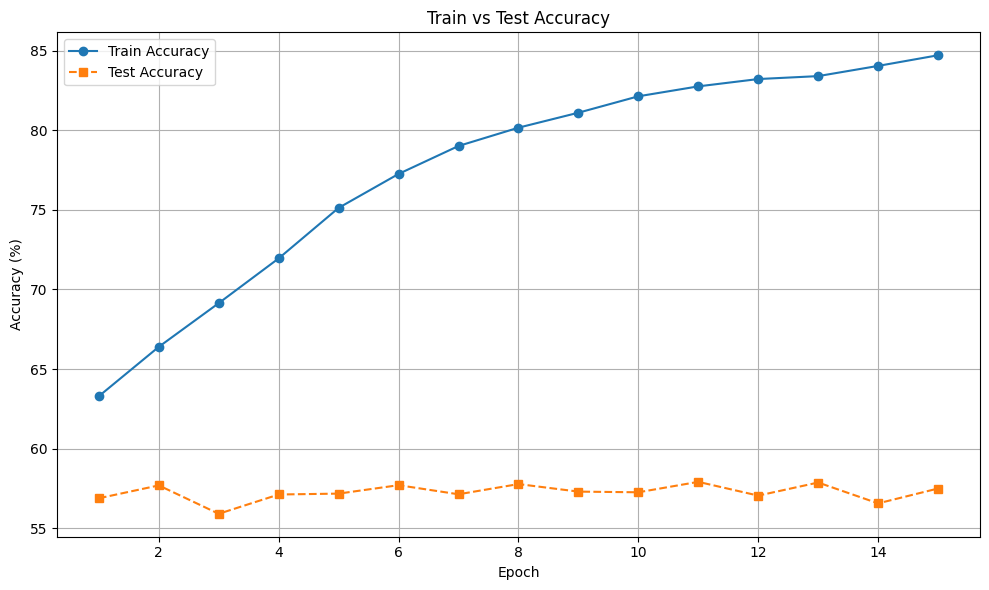

In [22]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 's--', label='Test Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_accuracy(train_accuracies, test_accuracies)

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

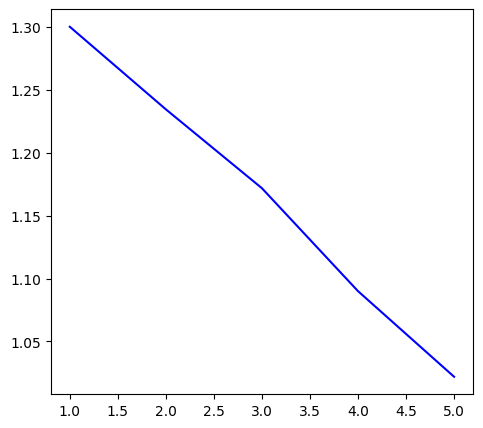

In [20]:
plt.figure(figsize=(12, 5))

# Wykres treningu i walidacji loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", color="red")
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Wykres treningu i walidacji accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", color="red")
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
from PIL import Image
def predict_emotion(image_path):
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    emotion_labels = ['angry','disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    return emotion_labels[predicted.item()]

print(predict_emotion("/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/train/angry/1.jpg"))

In [ ]:
import time

start_time = time.time()

for i, (images, labels) in enumerate(train_loader):
    if i == 5:  # Pobranie tylko 5 batchy, żeby zobaczyć czas
        break

print(f"Czas wczytania 5 batchy: {time.time() - start_time:.2f} sekund")
